# Santander Customer Transaction Prediction

## Team members

- [Julie DORNAT](https://github.com/JulieDornat) : 22001111
- [Oloruntobi Paul OLUTOLA](https://github.com/OloruntobiOlutola) 22504382
- [Sukhjot KAUR](https://github.com/Sukhjot-Kaur-AI) 22510515


## Table of contents

- [Santander Customer Transaction Prediction](#santander-customer-transaction-prediction)
  - [Team members](#team-members)
  - [Table of contents](#table-of-contents)
  - [Problem Framing](#problem-framing)
    - [Business Problem](#business-problem)
    - [Business Objectives](#business-objectives)
    - [Usage](#usage)
    - [Machine learning approach](#machine-learning-approach)
    - [Existing solutions](#existing-solutions)
    - [Expected results](#expected-results)
      - [General Assumptions](#general-assumptions)
      - [Models](#models)
      - [Performance](#performance)
      - [Optimization](#optimization)
  - [Configurations](#configurations)
    - [Library importations](#library-importations)
    - [Utility functions](#utility-functions)
  - [Data Collection](#data-collection)
    - [Workspace setup](#workspace-setup)
    - [Data importation](#data-importation)
    - [Licenses](#licenses)
    - [Dataset visualization](#dataset-visualization)
  - [Exploration Data Analysis (EDA)](#exploration-data-analysis-eda)
    - [Data cleaning](#data-cleaning)
    - [Split test and train sets](#split-test-and-train-sets)
    - [Visualize target values](#visualize-target-values)
    - [Correlation matrix](#correlation-matrix)
    - [Standardization](#standardization)
  - [Downsampling Models](#downsampling-models)
    - [Logistic Regression](#logistic-regression)
    - [LightGBM](#lightgbm)
    - [CatBoost Classifier](#catboost-classifier)
    - [Linear SVC (resampled data)](#linear-svc-resampled-data)
    - [Random Forest Classifier](#random-forest-classifier)
    - [Gaussian Naive Bayes](#gaussian-naive-bayes)
    - [Gradient Boosting Classifier](#gradient-boosting-classifier)
    - [SVC](#svc)
    - [KNN](#knn)
    - [Multi-layer Perceptron](#multi-layer-perceptron)
    - [XGBoost Classifier](#xgboost-classifier)
  - [Models Without downsampling](#models-without-downsampling)
    - [Logistic Regression](#logistic-regression)
    - [CatBoost Classifier](#catboost-classifier)
    - [LightGBM](#lightgbm)
    - [Linear SVC](#linear-svc)
    - [Random Forest Classifier](#random-forest-classifier)
    - [Gaussian Naive Bayes](#gaussian-naive-bayes)
    - [Gradient Boosting Classifier](#gradient-boosting-classifier)
    - [SVC](#svc)
    - [KNN](#knn)
    - [Multi-Layer Perceptron](#multi-layer-perceptron)
    - [XGBoost Classifier](#xgboost-classifier)
  - [Models with class weight](#models-with-class-weight)
    - [Logistic Regression](#logistic-regression)
    - [LightGBM](#lightgbm)
    - [CatBoost](#catboost)
    - [Linear SVC](#linear-svc)
    - [Random Forest Classifier](#random-forest-classifier)
    - [XGBoost](#xgboost)
  - [Models with Hyperparameter tunning](#models-with-hyperparameter-tunning)
    - [LightGBM](#lightgbm)
    - [Logistic Regression](#logistic-regression)
    - [Gaussian Naive Bayes](#gaussian-naive-bayes)
    - [XGBoost](#xgboost)
    - [Random Forest Classifier](#random-forest-classifier)
    - [CatBoost](#catboost)
   - [Conclusion](#conclusion)

## Problem Framing
### Business Problem
Depending on their needs, consumers are more or less likely to take out a loan, to be receptive to a promotion. To increase their customer base and build customer loyalty, companies run marketing campaigns, creating a new need and incentivizing customers to buy.
Santander wants to identify customers who are likely to make a specific future financial transaction by doing information mining with machine learning.

### Business Objectives
1.	Predict customer transactions in order to increase the effectiveness of marketing campaigns and increase conversion rate by targeting customers who are more inclined to transact.
2.	The objective of this model is therefore to reduce marketing costs by prioritizing the resources invested in attracting and personalizing offers to the most receptive customers.

### Usage
Predictions will be used by the marketing team to:
-	generate a ranked list of customers from highest → lowest probability
-	deploy marketing campaigns (emails, offers, upselling)
-	evaluate campaign ROI

### Machine learning approach
Customer data for a given transaction is provided in an anonymized and labeled manner in the dataset train.csv present on [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/santander-customer-transaction-prediction-dataset/data). Each instance is described by 200 real features and the desired prediction is provided as an integer (either 0 if there is no transaction, or 1 if there is a transaction). It is therefore a supervised learning task and more specifically a binary classification problem. 
In addition, the dataset is subject to a strong class imbalance. This reflects real-world business behavior. In general, the conversion rate of customers is naturally rare (often below 10%). As a result, class 1, describing the customers carrying out the transaction, is in the minority while class 0 is mostly represented. Most customers do not perform the transaction.

### Existing solutions
Before ML:
- Business teams guess based on demographics
- Rule-based segmentation
- Past behaviors used manually

Broad marketing blasts → expensive and often ineffective (Sending promotional messages to everyone or to a very large group, without using ML or targeting )

Comparable problems from industry:
- Credit scoring (Scoring means using a trained ML model to assign a score (often a probability) to each customer.)
- Customer churn prediction
- Purchase/upsell prediction


Existing experience you can reuse:
- Binary classification frameworks
- Imbalanced classification techniques


### Expected results 
#### General Assumptions
**Data-Related assumptions:**
- Features contain sufficient signal about customer behavior (var_0 ... var_199)
- No data leakage exists between train/test splits
- Feature distributions remain stable over time
- Anonymized features are representative and sufficient for prediction 

**Data Preparation assumptions:**
- Dataset contains no missing values 
- Outliers are removed entirely
- All features are standardized
- Class imbalance reflects real-world conversion rates (minority class is rare) 

**Modeling Assumptions:**
- Imbalance handling works accross models
- Historical patterns predict future customer behavior
- Customers' future transactions depend on their feature profiles 

**Usage Assumptions:**
- Predictions will be used ethically and legally
- Marketing team will act on model outputs responsibly


#### Models
To conduct our study, we relied on the article provided (https://iopscience.iop.org/article/10.1088/1757-899X/1088/1/012032) 

**System Type:** Offline prediction system (batch scoring), not real-time.

**Approach:** We test multiple models and compare them across three configurations to evaluate imbalance-handling strategies:
1. Downsampled training data (balanced class distribution)
2. Class-weighted models (on imbalanced data)
3. Hyperparameter-tuned + PCA models (optimized for F1-score)


| Model | Expected results | Key Caracteristics | Assumptions
|:-----------------------------|:-----------------------------|:---------------------------------------|:---------------------------------------|
| Binary Logistic Regression | Perform well with large dataset; moderate F1 if signal is linear; Fast | Interpretable, Binary/Probability outputs | Binary target; Target is a dependent variable; Independent observations (input samples) otherwise the standard errors are biased; No highly correlated independent variables; Independent variables are linearly related to the log odds of the dependent variable; large sample size and representativeness of all categories |
| Linear SVC | Faster than SVC;  Good linear separator for high‑dimensional data; fast training | Sensitive to noisy observations (require regularization); Not scale invariant | Appropriate for linearly separable data; Representativeness of all categories |
| SVC (RBF) | Slow Training; Accuracy of 90.43% and recall of 5.32% for class 1 (according to the paper) |  Quadratic programming problem (quadratic complexity depending on the number of features and samples); Sensitive to noisy observations (require regularization); Not scale invariant; Excels in high-dimensional spaces; Memory efficient | Can handle nonlinearly separable data; Representativeness of all categories |
| K-Nearest Neighbors | may give high accuracy (95.71%) but poor minority recall (0%) in high dim (according to the paper); Modest performance (compare every point) | Sensitive to outliers and sparse data; Loss of accuracy for too many features | K should be an odd number; Representativeness of all categories; Only when local similarity is meaningful |
| Gradient Boosting Classifier | Strong predictive power when tuned; risk of overfitting if not regularized | Less sentive to noise (it smooths updates using gradient); Suitable for complex problems; Important choice of learning rate |  |
| LightGBM | Fast training; low memory; High performance | Gradient boosting with histogram-based splits; Preferred when training speed and memory footprint matter | |
| CatBoost Classifier | Handles categorical structure; Stable without heavy preprocessing | Gradient boosting with categorical support  | |
| Gaussian Naive Bayes | Accuracy of 14.69% (according to the paper); recall of 93.36% for class 1 | Independent features given the class; Continuous features are normally distributed; discrete features have multinomial distribution | |
| Multi-Layer Perceptron | Can model complex patterns; Sensitive to scaling | Feedforward neural network | Requires normalized input; Sufficient dataset size |
| XGBoost | High performance for tabular data | Optimized gradient boosting; Good for large datasets with nonlinear interactions | |
| Random Forest Classifier | Good general performance | Robust; Tree ensemble; Handles noisy features; Parallelizable | Stable feature importance |


#### Performance
To evaluate the quality of predictions made by our models of machine learning, we will use performance metrics. The precision measures the portion of correctly classified transactions over all the prediction of transactions. The recall is the fraction of all transactions that were classified correctly.
For imbalanced dataset, accuracy is not meaningful. Indeed, the models can always predict the majority class and consequently have a high accuracy. This is why the f1-score, calculated by combining the recall and the precision is preferred in this context. F1 score is a trade-off between the correctness of predictions and the model’s ability to distinguish each class.

In addition, to visualize the performance, the precision-recall curve (PRC) and the area under the curve (AUPRC) are plotted, as the ROC and AUC are not really adapted to unbalanced data, especially when the class of interest is in the minority. The AUPRC summarizes the performance of the model across the range of transaction class probability thresholds. The higher the AUPRC, the better the model for the positive class.

As part of our problem, we want to reduce the investment of marketing campaigns by mainly targeting the customers who are most likely to complete a transaction. Thus, we will tend to favor a high precision, as false positives are expensive.

- **Tuning metric:** F1-score (balances precision and recall for imbalanced data)
- **Evaluation metric:** PR-AUC (preferred over ROC-AUC for imbalanced classification where minority class matters)
- **Business metric:** Precision (false positives are costly in marketing campaigns)

#### Optimization

PCA
Hyperparameter tuning

downsampling
class weights

## Configurations

### Library importations

In [65]:
import os
import kagglehub
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import Any, Dict

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [66]:
np.random.seed(42)

### Utility functions

In [67]:
def reduce_mem_usage(df, verbose=True):
    """
    Summary:
        - The function tries to reduce a DataFrame's memory footprint by downcasting numeric columns to the smallest safe numpy dtype.
        - It measures memory before/after and prints the reduction. 
    Parameters:
        df : pd.DataFrame
            The input DataFrame to optimize.
        verbose : bool, optional
            If True, prints memory usage reduction details. Default is True.
    Returns:
        pd.DataFrame
            The optimized DataFrame with reduced memory usage.
    """
    numerics = ['int8','int16', 'int32', 'int64', 'float32', 'float64']  # Removed float16
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                # Skip float16 to avoid overflow issues with pandas display
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [68]:
def visualize_class_distribution(y):
    """
    Summary:
        - This function visualizes the distribution of classes in the target variable using a bar plot.
    Parameters:
        y : pd.Series or np.array
            The target variable containing class labels.
    Returns:
        None
    """
    class0 = (y == 0).sum()
    class1 = (y == 1).sum()

    data = {
        'Class': ['Class 0', 'Class 1'],
        'Count': [class0, class1]
    }

    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Class', y='Count', data=data)
    plt.title('Class Distribution (Train Set)')
    plt.show()

In [69]:
def save_model(model, filename):
    """
    Summary:
        - This function saves a machine learning model to a specified file within a 'results' directory
    Parameters:
        model : object
            The machine learning model to be saved.
        filename : str
            The name of the file to save the model to.
    Returns:
        None
    """
    # Ensure results folder exists
    folder = "results"
    os.makedirs(folder, exist_ok=True)

    # Build full path
    filepath = os.path.join(folder, filename)

    # Save model
    with open(filepath, 'wb') as file:
        pkl.dump(model, file)

    print(f"Model saved to: {filepath}")

In [70]:
def load_model(filename):
    """ 
    Summary:
        - This function loads a machine learning model from a specified file within a 'results' directory
    Parameters:
        filename : str
            The name of the file to load the model from.
    Returns:
        object
            The loaded machine learning model.
    """
    # Build full path
    filepath = os.path.join("results", filename)

    # Load model
    with open(filepath, 'rb') as file:
        model = pkl.load(file)

    print(f"Model loaded from: {filepath}")
    return model

In [71]:
def show_classification_report(y_true, y_pred):
    """
    Summary:
        - This function generates a styled classification report as a pandas DataFrame with color coding for performance
    Parameters:
        y_true : array-like
            True labels.
        y_pred : array-like
            Predicted labels.
    Returns:
        pd.io.formats.style.Styler
            A styled DataFrame representing the classification report.
    """
    # Generate report as dict
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Convert to DataFrame & transpose
    df = pd.DataFrame(report).transpose().round(4)

    # Reorder rows: class labels first, then accuracy + averages
    row_order = [str(label) for label in sorted(df.index[:-3])] + ["accuracy", "macro avg", "weighted avg"]
    df = df.loc[row_order]

    # Fix accuracy row: put accuracy value in f1-score column
    if "accuracy" in df.index:
        df.loc["accuracy", "precision"] = None
        df.loc["accuracy", "recall"] = None
        df.loc["accuracy", "f1-score"] = report["accuracy"]
    
    # Color encoding for good / medium / bad values
    def color_scale(s):
        colors = []
        for v in s:
            if pd.isna(v):
                colors.append("")  
            elif v >= 0.80:
                colors.append("background-color: rgba(0, 200, 0, 0.35)")   # green
            elif v >= 0.50:
                colors.append("background-color: rgba(255, 165, 0, 0.35)") # yellow/orange
            else:
                colors.append("background-color: rgba(255, 0, 0, 0.35)")   # red
        return colors

    numeric_cols = ["precision", "recall", "f1-score"]
    styled = df.style.apply(color_scale, subset=numeric_cols)

    # Make column headers bold
    styled = styled.set_properties(**{"font-weight": "bold"}, subset=pd.IndexSlice[:, numeric_cols])

    return styled


In [72]:
def evaluate_model(model_name, y_true, y_pred, results):
    """
    Stores full classification report.
    """
    results[model_name] = {
        "report": classification_report(y_true, y_pred)
    }

In [73]:
def train_and_save_model(
    model,
    model_name,
    X_train,
    y_train,
    X_test,
    y_test,
    saved_results,
    sampled=False
):
    """
    Summary:
        - This function trains a machine learning model, makes predictions, generates a classification report, and saves the trained model to a file.
    Parameters:
        model : object
            The machine learning model to be trained.
        model_name : str
            The base name for saving the model file.
        X_train : pd.DataFrame or np.array
            Training feature set.
        y_train : pd.Series or np.array
            Training target variable.
        X_test : pd.DataFrame or np.array
            Testing feature set.
        y_test : pd.Series or np.array
            Testing target variable.
        sampled : bool, optional
            Indicates if the model was trained on a downsampled and scaled dataset. Default is False.
    Returns:
        - report : A styled classification report as a pandas DataFrame.
    """
    # ---- Train model ----
    model.fit(X_train, y_train)

    # ---- Predictions ----
    y_pred = model.predict(X_test)

    # ---- Classification Report ----
    report = show_classification_report(y_test, y_pred)

    # ---- Build filename ----
    suffix = "_sampled" if sampled else ""
    new_model_name = model_name + suffix
    filename = f"{new_model_name}.pkl"

    # ---- Save results ----
    evaluate_model(new_model_name, y_test, y_pred, saved_results)

    # ---- Save model ----
    save_model(model, filename)

    return report

In [74]:
def parse_classification_report_full(report_str: str) -> Dict[str, float]:
    """
    Parse a classification report string and extract:
    - accuracy
    - class_1_precision
    - class_1_recall
    - class_1_f1
    - macro_f1
    """
    lines = report_str.split("\n")
    extracted = {}

    for line in lines:
        parts = line.split()

        # Extract CLASS 1 metrics (minority class)
        if line.strip().startswith("1"):
            extracted["class_1_precision"] = float(parts[1])
            extracted["class_1_recall"] = float(parts[2])
            extracted["class_1_f1"] = float(parts[3])

        # Accuracy
        if line.strip().startswith("accuracy"):
            extracted["accuracy"] = float(parts[1])

        # Macro Avg
        if line.strip().startswith("macro avg"):
            extracted["macro_precision"] = float(parts[2])
            extracted["macro_recall"] = float(parts[3])
            extracted["macro_f1"] = float(parts[4])

    return extracted


In [75]:
def build_results_table(results: Dict[str, Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert a dictionary of model results containing classification report strings
    into a structured pandas DataFrame.

    Parameters
    ----------
    results : Dict[str, Dict[str, Any]]
        A dictionary where keys are model names and values contain at least:
        - "report": classification report string

    Returns
    -------
    pd.DataFrame
        A DataFrame indexed by model names containing accuracy and macro metrics.
    """
    rows = []

    if not results:
        return pd.DataFrame()  # Return empty DataFrame if no results

    for model_name, data in results.items():
        parsed = parse_classification_report_full(data["report"])
        parsed["model"] = model_name
        rows.append(parsed)

    df = pd.DataFrame(rows)
    return df.set_index("model")

In [ ]:

def plot_model_scores(df, sort_by="class_1_f1"):
    """
    Plot a clean, well-spaced comparison of Accuracy and F1 scores.
    Models are sorted by the metric of your choice.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing accuracy and macro_f1.
    sort_by : str
        Metric to sort by ("accuracy" or "macro_f1").
    """

    if df.empty:
        print("No results to plot.")
        return

    # Sort by chosen metric (descending)
    df = df.sort_values(by=sort_by, ascending=False)

    _, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

    # Class 1 Recall
    axes[0].plot(df.index, df["class_1_recall"], marker='o')
    for i, v in enumerate(df["class_1_recall"]):
        axes[0].text(i, v + 0.01, f"{v:.2f}", ha="center")
    axes[0].set_title("Recall (Minority Class = 1)")
    axes[0].set_ylabel("Recall")
    axes[0].grid(True)

    # Class 1 Precision
    axes[1].plot(df.index, df["class_1_precision"], marker='o', color='orange')
    for i, v in enumerate(df["class_1_precision"]):
        axes[1].text(i, v + 0.01, f"{v:.2f}", ha="center")
    axes[1].set_title("Precision (Minority Class = 1)")
    axes[1].set_ylabel("Precision")
    axes[1].grid(True)

    # Class 1 F1
    axes[2].plot(df.index, df["class_1_f1"], marker='o', color='orange')
    for i, v in enumerate(df["class_1_f1"]):
        axes[2].text(i, v + 0.01, f"{v:.2f}", ha="center")
    axes[2].set_title("F1 Score (Minority Class = 1)")
    axes[2].set_ylabel("F1")
    axes[2].grid(True)

    # Macro F1
    axes[3].plot(df.index, df["macro_f1"], marker='o', color='green')
    for i, v in enumerate(df["macro_f1"]):
        axes[3].text(i, v + 0.01, f"{v:.2f}", ha="center")
    axes[3].set_title("Macro F1 Score (Balanced Evaluation)")
    axes[3].set_ylabel("Macro F1")
    axes[3].grid(True)

    plt.xticks(rotation=45, ha="right")
    plt.subplots_adjust(bottom=0.25, hspace=0.35)
    plt.show()


In [77]:
def prepare_model_for_imbalance(model, y_train):
    """
    Summary:
        - Automatically configures a model with the best imbalance-handling parameters.
    Parameters:
        model : object
            The machine learning model to be configured.
        y_train : pd.Series or np.array
            The target variable from the training set.
    Returns:
        object
            The configured machine learning model.
    """

    # compute class weights / imbalance ratio
    counter = Counter(y_train)
    maj = counter[0]
    minr = counter[1]

    imbalance_ratio = maj / minr  # used for scale_pos_weight etc.

    params = {}

    # ----- XGBoost -----
    if model.__class__.__name__ == "XGBClassifier":
        params["scale_pos_weight"] = imbalance_ratio

    # ----- LightGBM -----
    elif model.__class__.__name__ == "LGBMClassifier":
        params["is_unbalance"] = True
        params["scale_pos_weight"] = imbalance_ratio

    # ----- CatBoost -----
    elif model.__class__.__name__ == "CatBoostClassifier":
        params["class_weights"] = [1, imbalance_ratio]

    # ----- Logistic Regression -----
    elif model.__class__.__name__ == "LogisticRegression":
        params["class_weight"] = "balanced"

    # ----- Random Forest -----
    elif model.__class__.__name__ == "RandomForestClassifier":
        params["class_weight"] = "balanced"

    # ----- LinearSVC -----
    elif model.__class__.__name__ == "LinearSVC":
        params["class_weight"] = "balanced"

    # Set parameters dynamically
    for key, value in params.items():
        try:
            setattr(model, key, value)
        except:
            pass

    return model


In [78]:
def tune_model_with_pca_search(
    model,
    param_dist,
    X_train,
    y_train,
    n_iter=40,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=False
):
    """
    Generic hyperparameter tuning function with PCA as a search parameter.
    
    Parameters
    ----------
    model : estimator
        
    param_dist : dict
        Param distributions for the *model only*. Do NOT prefix with "model__".
        
    X, y : data
        
    pca_components_list : list
        List of PCA components to search. 
        
    Returns
    -------
        best_model
    """

    # Default PCA search space
    pca_components_list = [0.80, 0.85, 0.90, 0.95]

    # Build pipeline: PCA → Model
    pipe = Pipeline([
        ("pca", PCA()),
        ("model", model),
    ])

    # Expand param grid: add "model__" prefix  
    param_dist_expanded = {f"model__{k}": v for k, v in param_dist.items()}

    # Add PCA search parameter
    param_dist_expanded["pca__n_components"] = pca_components_list

    # Randomized search
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist_expanded,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        verbose=verbose
    )
    
    search.fit(X_train, y_train)

    return search.best_estimator_

## Data Collection

### Workspace setup
1. **Create a new project folder**  
Inside this folder, you will place your source code, notebooks, datasets, and configuration files (such as `requirements.txt`).
2. **Set up a virtual environment** 
Use a tool such as `venv`, `pipenv`, or `conda` to isolate your project’s dependencies from the rest of your system.
3. **Install project dependencies**  
Use the `requirements.txt` file to install all required libraries and ensure your environment matches the project specifications.


### Data importation
Import the data [Santander Customer Transaction Prediction Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/santander-customer-transaction-prediction-dataset/data) from Kaggle (~308.2 MB)

Ways to download:
- Kaggle website: manual download from the page (requires signing).
- Kaggle Python API: programmatic download via kaggle and kagglehub libraries.
- Kaggle CLI: command-line download.


### Licenses
- [Kaggle dataset (train.csv)](https://www.kaggle.com/datasets/lakshmi25npathi/santander-customer-transaction-prediction-dataset/data): license not specified on the dataset page.
- [Related paper](https://iopscience.iop.org/article/10.1088/1757-899X/1088/1/012032) : CC BY license - the work can be reproduced, adapted and shared so long as the authors are credited.  
Yudhistira Arie Wijaya, Nana Suarna, Iin, Ryan Hamonangan, and R. Nining, "Comparison of machine learning algorithm for Santander dataset," IOP Conference Series: Materials Science and Engineering, Volume 1088, 2021. Published under CC BY — the work may be reproduced, adapted, and shared provided the original authors are credited. DOI: 10.1088/1757-899X/1088/1/012032

In [79]:
# Download the dataset first to see what files are available
dataset_path = kagglehub.dataset_download("lakshmi25npathi/santander-customer-transaction-prediction-dataset")

print(f"Dataset downloaded to: {dataset_path}")
print("\nFiles in the dataset:")
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        print(f"  - {file}")


Dataset downloaded to: /Users/olutolaoloruntobipaul/.cache/kagglehub/datasets/lakshmi25npathi/santander-customer-transaction-prediction-dataset/versions/1

Files in the dataset:
  - test.csv
  - train.csv


This project uses only `train.csv`, which contains 200 anonymized numeric features and a binary target variable (0 = no transaction, 1 = transaction).

In [80]:
df = pd.read_csv(os.path.join(dataset_path, "train.csv"))

### Dataset visualization

In [81]:
print("Initial DataFrame shape:", df.shape)
print(f"The dataset contains {df.shape[0]} samples and {df.shape[1]} variables.")

Initial DataFrame shape: (200000, 202)
The dataset contains 200000 samples and 202 variables.


In [82]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


## Exploration Data Analysis (EDA)

### Data cleaning
- Study the dataset by visualizing the distributions, the missing values and the outliers. 
- Identify non numerical types checking data type.
- Convert the data into practical formats.

In [84]:
# Visualize features' distribution
df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [ ]:
# Show rows with any null values
df[df.isnull().any(axis=1)]

Series([], dtype: int64)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199


In [86]:
# Visualize class distribution
df['target'].value_counts()

target
0    179902
1     20098
Name: count, dtype: int64

In [87]:
# Visualize memory usage
df.memory_usage()

Index          132
ID_code    1600000
target     1600000
var_0      1600000
var_1      1600000
            ...   
var_195    1600000
var_196    1600000
var_197    1600000
var_198    1600000
var_199    1600000
Length: 203, dtype: int64

Observations:
- The dataset contains a very large number of features (200), making visualization per-feature and direct interpretability difficult.
- The target distribution shows a strong class imbalance: only ~10.05% of samples belong to the positive class (transaction = 1).
- Features have very different means and standard deviations. Most of them are not zero-centered, and several contain negative values.
- All variables except ID_code are numeric.
- The dataset contains no missing values.
- Numeric types are consistent across all features.
- The memory is used uniformely by all variables.

Implications:
- Because feature scales vary widely, scaling is required for distance-based or gradient-sensitive models (e.g., SVM, KNN, MLP).
- The presence of extreme values suggests the use of outlier-handling techniques (e.g., IQR filtering).
- The ID_code column carries no predictive information and can be removed.
- Use dimensionality reduction (PCA) or feature selection to reduce  dimensionality and keep only the most relevant features.
- Adopt class imbalance strategies such as class weights or downsampling.


In [88]:
# Remove the ID_code column
df = df.drop(columns=['ID_code'])
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [89]:
total_outliers = 0

# Detect outliers using the IQR method

outlier_indices = set()

for col in df.columns.drop('target'):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_idx = df[outlier_mask].index.tolist()
    
    #print(f"Column: {col}, Outliers detected: {len(outlier_idx)}")
    
    # Add indices to the set (automatically removes duplicates)
    outlier_indices.update(outlier_idx)
    total_outliers += len(outlier_idx)
print(f"Total outliers detected across all columns: {total_outliers}")
print(f"Total unique rows with outliers: {len(outlier_indices)}")

# (Optional) View the unique outlier rows
outlier_rows = df.loc[list(outlier_indices)]
print(f"\nOutlier rows shape: {outlier_rows.shape}")

Total outliers detected across all columns: 26536
Total unique rows with outliers: 24896

Outlier rows shape: (24896, 201)


In [90]:
# Check non numeric columns to transform data into a more efficient type for the training
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
non_numeric_cols

Index([], dtype='object')

In [91]:
# remove outlier rows from the original dataframe
df_cleaned = df.drop(index=outlier_indices)
df_cleaned.shape

(175104, 201)

### Split test and train sets
Before training the models, the dataset is divided into two subsets: a training set and a test set.
The training set is used during model development, including cross-validation, while the test set is kept aside to evaluate final performance.

Given the large size of the dataset and the fact that both classes are sufficiently represented, we allocate 20% of the data to the test set.
We also apply stratification to ensure that the class imbalance is preserved in both splits.


In [92]:
X = df_cleaned.drop(columns=['target'])
y = df_cleaned['target']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

### Visualize target values
Highligh the imbalance effect and take it into account into our solution.

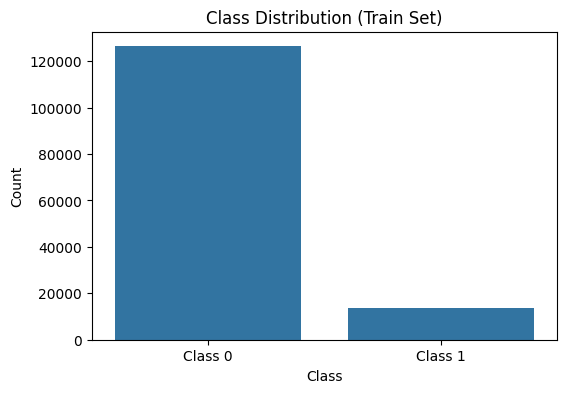

In [94]:
visualize_class_distribution(y_train)

To address the imbalance issue and ensures that our models learn patterns relevant to the minority class, we adopt two complementary strategies:
- **Downsampling**  
We reduce the number of samples in the majority class by randomly selecting a subset whose size matches the minority class.
A downsampled copy of the training set is created to observe how models behave on a more balanced distribution.
While downsampling ensures that both classes are equally represented in the batches, it may also lead to information loss and introduce bias.
- **Class weights**  We assign higher weights to the minority class so that misclassifying a positive sample incurs a larger penalty.
This helps the model pay more attention to the rare class without altering the dataset itself.

We avoid oversampling techniques (e.g., SMOTE or random oversampling) because they increase the number of samples and therefore the computational cost.
Since our objective is to keep the training time reasonable, oversampling is not used in our approach.

target
0    13684
1    13684
Name: count, dtype: int64
target
0    126399
1     13684
Name: count, dtype: int64


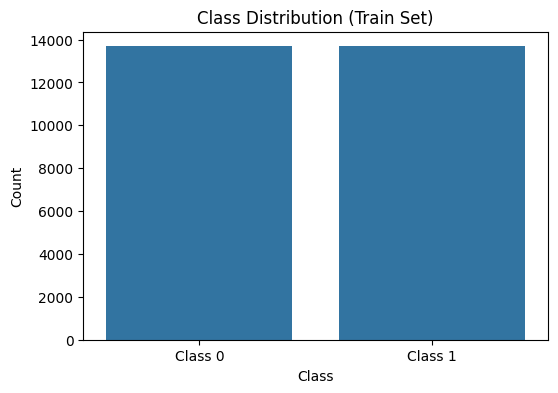

In [95]:
# Downsampling
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
rus = RandomUnderSampler(sampling_strategy='majority')
X_resampled_down, y_resampled_down = rus.fit_resample(X_train_copy, y_train_copy)
print(y_resampled_down.value_counts())
print(y_train.value_counts())
visualize_class_distribution(y_resampled_down)

In [96]:
# Class weigthing
class_weights = {0: 1, 1: round((len(y_train) / sum(y_train)),2)}  # Adjust weights based on class distribution
print(f"Class weights: {class_weights}")

Class weights: {0: 1, 1: 10.24}


### Correlation matrix
Feature engineering is crucial in this competition, which is why we examine correlations between variables. To explore potential linear relationships, we compute the correlation matrix and highlight the pairs of features with the highest absolute correlations.

This approach allows us to detect redundant variables or confirm the absence of strong linear structure. However, it does not capture non-linear dependencies.

**Expected results**
The features are anonymized, high-dimensional, and likely derived from non-linear transformations. Consequently, strong linear correlations between variables are unlikely.

In [97]:
scorr = df_cleaned.corr(numeric_only=True)
scorr

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.050677,0.047490,0.057339,0.011219,0.012102,0.030933,0.067612,-0.002929,0.019535,...,0.054470,0.047234,-0.041799,-0.018757,-0.022275,0.028054,0.024125,-0.036136,-0.051309,0.024045
var_0,0.050677,1.000000,0.000447,0.005772,0.003607,0.001497,0.003588,0.006565,0.002388,0.003740,...,0.002344,0.000057,-0.005919,0.002756,-0.001463,0.002069,0.002914,0.000658,-0.004247,0.002421
var_1,0.047490,0.000447,1.000000,0.002469,-0.000130,0.001733,-0.000727,0.002896,0.001547,0.003268,...,0.006455,0.003558,-0.001848,0.000736,-0.002533,0.000724,0.000386,-0.004665,-0.005277,0.002958
var_2,0.057339,0.005772,0.002469,1.000000,0.000771,0.000612,0.000792,0.000188,-0.001774,0.001454,...,-0.000375,0.001336,-0.002770,0.002097,0.002122,0.000584,0.004006,0.002382,0.000207,0.004883
var_3,0.011219,0.003607,-0.000130,0.000771,1.000000,0.000156,0.003662,-0.000779,0.001929,0.003534,...,-0.000231,0.001728,-0.002122,0.001135,-0.000593,0.002108,-0.001852,0.001307,-0.003154,-0.000276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.028054,0.002069,0.000724,0.000584,0.002108,0.005189,-0.001078,0.000565,0.002112,0.000198,...,0.003629,0.002050,-0.003227,-0.003516,-0.000303,1.000000,0.002843,-0.002592,-0.000202,0.002546
var_196,0.024125,0.002914,0.000386,0.004006,-0.001852,-0.000160,0.001153,0.006531,0.000535,-0.003881,...,-0.001792,0.001177,-0.003472,-0.006053,-0.003678,0.002843,1.000000,-0.001325,-0.000204,0.001853
var_197,-0.036136,0.000658,-0.004665,0.002382,0.001307,-0.000746,-0.001695,-0.004202,0.004578,-0.004864,...,-0.005261,0.000397,-0.001156,0.005578,0.001027,-0.002592,-0.001325,1.000000,0.000251,0.005727
var_198,-0.051309,-0.004247,-0.005277,0.000207,-0.003154,-0.000949,-0.000902,-0.001469,0.000850,0.004268,...,-0.000754,0.001345,0.004206,0.001747,0.003350,-0.000202,-0.000204,0.000251,1.000000,-0.005660


In [98]:
np.fill_diagonal(scorr.values, 0)
top_pairs = scorr.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_4_pairs = top_pairs.head(10)
print("Top 4 correlated pairs:\n", top_4_pairs)

Top 4 correlated pairs:
 var_81   target     0.080109
target   var_139    0.073132
var_12   target     0.068957
var_6    target     0.067612
var_53   target     0.062227
var_26   target     0.062202
target   var_110    0.061564
         var_146    0.060576
var_174  target     0.059820
var_76   target     0.059430
dtype: float64


The target appears in the 10 most correlated feature pairs. The highest correlation coefficient does not exceed 0.09, which is considered very low. This indicates that the features cannot be reduced based on the correlation matrix, as there are no significant linear relationships.

### Standardization

In [141]:
# Standardize the features of the inbalanced dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
# Standardize the features of the balanced dataset (downsample)
scaler_sampled = StandardScaler()
X_resampled_train_scaled = scaler.fit_transform(X_resampled_down)
X_resampled_test_scaled = scaler.transform(X_test)

## Downsampling Models

Trying the models for the sampled data

### Logistic Regression
Logistic regression is a basic model for binary classification. It produces the probabilities of belonging to each class via the sigmoid function. Specifically, the model assigns to each instance a probability of a transaction and predicts whether a transaction occurs based on a threshold (default is 0.5).

**Key hyperparameters**
- Penalty: Type of regularization applied to the coefficients.
    - Lasso (L1): reduces the values of the coeffients exactly to zero, useful for feature elimination.
    - Ridge (L2): shrinks coefficients close to zero.
    - ElasticNet: combines L1 and L2 regularization.
- C: Inverse of regularization strength. Higher values reduce regularization.
- tol: Stopping criterion for the gradient descent.

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- Resampling

In [101]:
saved_results = {}

In [102]:
report = train_and_save_model(
    model=LogisticRegression(),
    model_name="logistic_regression",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=True
)

Model saved to: results/logistic_regression_sampled.pkl


In [103]:
report

,precision,recall,f1-score,support
0,0.981600,0.560100,0.713200,31600.000000
1,0.181900,0.903200,0.302800,3421.000000
accuracy,nan,nan,0.593615,0.593600
macro avg,0.581800,0.731700,0.508000,35021.000000
weighted avg,0.903500,0.593600,0.673100,35021.000000


**Results**  
F1-score: Low 0.30 due to precision collapse.

Precision: Low (0.18), too many false positives.

Interpretation: Better recall but business-unsafe.

### LightGBM
LightGBM is a fast gradient boosting framework optimized for large datasets and high-dimensional features.

**Key hyperparameters**
- num_leaves: Maximum number of leaves per tree.
- max_depth: Maximum depth of each tree.
- learning_rate: Step size.
- n_estimators: Number of boosting iterations.
- boosting_type: 'gbdt' or 'dart'.

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- Downsampling

In [ ]:
report  = train_and_save_model(
    model=LGBMClassifier(verbosity = -1),
    model_name="lgbm_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=True
)
report

Model saved to: results/lgbm_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.983200,0.570200,0.721800,31600.000000
1,0.186500,0.910000,0.309500,3421.000000
accuracy,nan,nan,0.603381,0.603400
macro avg,0.584800,0.740100,0.515600,35021.000000
weighted avg,0.905400,0.603400,0.681500,35021.000000


**Results**  
F1-score: Low 0.30 from oversampling (same pattern: precision collapses).

Precision: Very low (0.20), generating too many false positives.

Interpretation: Recall-oriented but commercially unusable.

### CatBoost Classifier
CatBoost is a gradient boosting algorithm that handles categorical features natively.

**Key hyperparameters**
- iterations: Number of boosting rounds.
- learning_rate: Step size for each iteration.
- depth: Maximum depth of trees.
- l2_leaf_reg: L2 regularization term.

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- Downsampling

In [105]:
report  = train_and_save_model(
    model=CatBoostClassifier(verbose=False),
    model_name="cat_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=True
)
report

Model saved to: results/cat_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.986300,0.603300,0.748700,31600.000000
1,0.201100,0.922500,0.330300,3421.000000
accuracy,nan,nan,0.634505,0.634500
macro avg,0.593700,0.762900,0.539500,35021.000000
weighted avg,0.909600,0.634500,0.707800,35021.000000


**Results**  
F1-score: Drops to 0.34 for class 1 because precision collapses under oversampling.

Precision: Very low (0.21), leading to many false positives — not suitable for business.

Interpretation: High recall but commercially unacceptable.

### Linear SVC (resampled data)

Linear SVC is a linear Support Vector Machine that finds the hyperplane maximizing the margin between classes.

**Key hyperparameters**
- C: Regularization strength. Lower values increase regularization.
- loss: Loss function (hinge or squared_hinge).
- class_weight: Optionally adjust weights for imbalanced classes.

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- Downsampling

In [106]:
report  = train_and_save_model(
    model=LinearSVC(),
    model_name="linear_svc_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=True
)
report

Model saved to: results/linear_svc_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.981800,0.561000,0.714000,31600.000000
1,0.182300,0.903800,0.303300,3421.000000
accuracy,nan,nan,0.594472,0.594500
macro avg,0.582000,0.732400,0.508700,35021.000000
weighted avg,0.903700,0.594500,0.673900,35021.000000


**Results**  
F1-score: Similar oversampling effect: F1 drops to 0.30 due to loss of precision.

Precision: Extremely low (0.18), high false-positive cost.

Interpretation: Unsuitable for business use.

### Random Forest Classifier
Random Forest is an ensemble of decision trees, with predictions aggregated by majority vote.

**Key hyperparameters**
- n_estimators: Number of trees.
- max_depth: Maximum depth of each tree.
- min_samples_split: Minimum samples required to split a node.
- max_features: Maximum number of features considered at each split.

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- Downsampling

In [107]:
report  = train_and_save_model(
    model=RandomForestClassifier(),
    model_name="rf_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=True
)
report

Model saved to: results/rf_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.976200,0.558500,0.710500,31600.000000
1,0.176600,0.874300,0.293800,3421.000000
accuracy,nan,nan,0.589389,0.589400
macro avg,0.576400,0.716400,0.502200,35021.000000
weighted avg,0.898100,0.589400,0.669800,35021.000000


**Results**  
F1-score: Drops to 0.29 due to low precision.

Precision: 0.17, too many false positives.

Interpretation: Oversampling hurts performance again even if there are a good recall.

### Gaussian Naive Bayes
Gaussian Naive Bayes is a probabilistic classifier assuming features are Gaussian and independent.

**Key hyperparameters**
- var_smoothing: Added to variances to avoid division by zero.

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- Downsampling

In [108]:
report  = train_and_save_model(
    model=GaussianNB(),
    model_name="nb_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=True
)
report

Model saved to: results/nb_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.986400,0.566700,0.719800,31600.000000
1,0.188200,0.928100,0.313000,3421.000000
accuracy,nan,nan,0.601982,0.602000
macro avg,0.587300,0.747400,0.516400,35021.000000
weighted avg,0.908500,0.602000,0.680100,35021.000000


**Results**  
F1-score: Falls to 0.31 due to precision collapse.

Precision: 0.19, too many false positives.

Interpretation: Oversampled NB not usable.

### Gradient Boosting Classifier
Gradient Boosting builds an ensemble of decision trees sequentially to reduce the errors of previous trees.

**Key hyperparameters**
- n_estimators: Number of trees.
- learning_rate: Step size for each iteration.
- max_depth: Maximum depth of each tree.
- subsample: Fraction of samples used per tree.

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- Downsampling

In [109]:
report  = train_and_save_model(
    model=GradientBoostingClassifier(),
    model_name="gb_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=True
)
report

Model saved to: results/gb_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.975700,0.615300,0.754700,31600.000000
1,0.194600,0.858500,0.317300,3421.000000
accuracy,nan,nan,0.639102,0.639100
macro avg,0.585200,0.736900,0.536000,35021.000000
weighted avg,0.899400,0.639100,0.712000,35021.000000


**Results**  
F1-score: Slight improvement to 0.32 thanks to oversampling.

Precision: Weak (0.19), generating too many false positives.

Interpretation: Business-unsafe despite better recall.

### SVC
SVC with RBF kernel is a non-linear SVM that transforms the input space using the RBF kernel to separate classes.

**Key hyperparameters**
- C: Regularization strength.
- gamma: Kernel coefficient, controls the influence of individual points.
- kernel: 'rbf' (default).
- class_weight: Adjusts weight of classes for imbalance.

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- Downsampling

In [110]:
report  = train_and_save_model(
    model=SVC(),
    model_name="sv_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=True
)
report

Model saved to: results/sv_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.985600,0.561200,0.715200,31600.000000
1,0.185700,0.924300,0.309300,3421.000000
accuracy,nan,nan,0.596699,0.596700
macro avg,0.585700,0.742800,0.512200,35021.000000
weighted avg,0.907500,0.596700,0.675600,35021.000000


**Results**  
F1-score: Falls to 0.31 due to precision collapse.

Precision: 0.19, too many false positives.

Interpretation: Oversampled SVC not usable.

### KNN
KNN predicts the class of an instance based on the majority class among its k nearest neighbors.

**Key hyperparameters**
- n_neighbors: Number of neighbors (k).
- weights: uniform or distance.
- metric: Distance metric (euclidean, manhattan, etc.).

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- Downsampling

In [111]:
report  = train_and_save_model(
    model=KNeighborsClassifier(),
    model_name="knn_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=True
)
report

Model saved to: results/knn_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.916700,0.899600,0.908000,31600.000000
1,0.208700,0.244700,0.225200,3421.000000
accuracy,nan,nan,0.835584,0.835600
macro avg,0.562700,0.572100,0.566600,35021.000000
weighted avg,0.847500,0.835600,0.841300,35021.000000


**Results**  
F1-score: Improves significantly (0.22) with sampling but stay low.

Precision: Low (0.20), high false-positive risk.

Interpretation: not business-ready.

### Multi-layer Perceptron
MLP is a feedforward neural network with one or more hidden layers.

**Key hyperparameters**
- hidden_layer_sizes: Number of neurons per layer.
- activation: Activation function (relu, tanh, logistic).
- solver: Optimization algorithm (adam, sgd).
- learning_rate_init: Initial learning rate.
- max_iter: Maximum number of iterations.

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- Downsampling

In [112]:
report  = train_and_save_model(
    model=MLPClassifier(),
    model_name="nn_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=True
)
report

Model saved to: results/nn_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.966500,0.546300,0.698000,31600.000000
1,0.164500,0.825200,0.274300,3421.000000
accuracy,nan,nan,0.573542,0.573500
macro avg,0.565500,0.685700,0.486200,35021.000000
weighted avg,0.888200,0.573500,0.656700,35021.000000


**Results**  
F1-score: Drops to 0.32 because precision collapses under oversampling.

Precision: Very low (0.19).

Interpretation: Oversampling harms neural network stability.

### XGBoost Classifier
XGBoost is a gradient boosting framework with regularization for decision trees.

**Key hyperparameters**
- n_estimators: Number of trees.
- max_depth: Maximum tree depth.
- learning_rate: Step size per iteration.
- subsample: Fraction of samples per tree.
- colsample_bytree: Fraction of features per tree.
- gamma: Minimum loss reduction to make a split.

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- Downsampling

In [113]:
report  = train_and_save_model(
    model=XGBClassifier(),
    model_name="xgb_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=True
)
report

Model saved to: results/xgb_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.979400,0.587000,0.734000,31600.000000
1,0.188500,0.886000,0.310800,3421.000000
accuracy,nan,nan,0.616202,0.616200
macro avg,0.583900,0.736500,0.522400,35021.000000
weighted avg,0.902100,0.616200,0.692700,35021.000000


**Results**  
F1-score: Moderate (0.31), showing partial ability to detect class 1.

Precision: Low (0.18), too many false positives.

Interpretation: Better recall but business-unsafe..

In [114]:
results_table = build_results_table(saved_results)
results_table

,class_1_precision,class_1_recall,class_1_f1,accuracy,macro_precision,macro_recall,macro_f1
model,,,,,,,
logistic_regression_sampled,0.18,0.90,0.30,0.59,0.58,0.73,0.51
lgbm_classifier_sampled,0.19,0.91,0.31,0.60,0.58,0.74,0.52
cat_classifier_sampled,0.20,0.92,0.33,0.63,0.59,0.76,0.54
linear_svc_classifier_sampled,0.18,0.90,0.30,0.59,0.58,0.73,0.51
rf_classifier_sampled,0.18,0.87,0.29,0.59,0.58,0.72,0.50
nb_classifier_sampled,0.19,0.93,0.31,0.60,0.59,0.75,0.52
gb_classifier_sampled,0.19,0.86,0.32,0.64,0.59,0.74,0.54
sv_classifier_sampled,0.19,0.92,0.31,0.60,0.59,0.74,0.51
knn_classifier_sampled,0.21,0.24,0.23,0.84,0.56,0.57,0.57


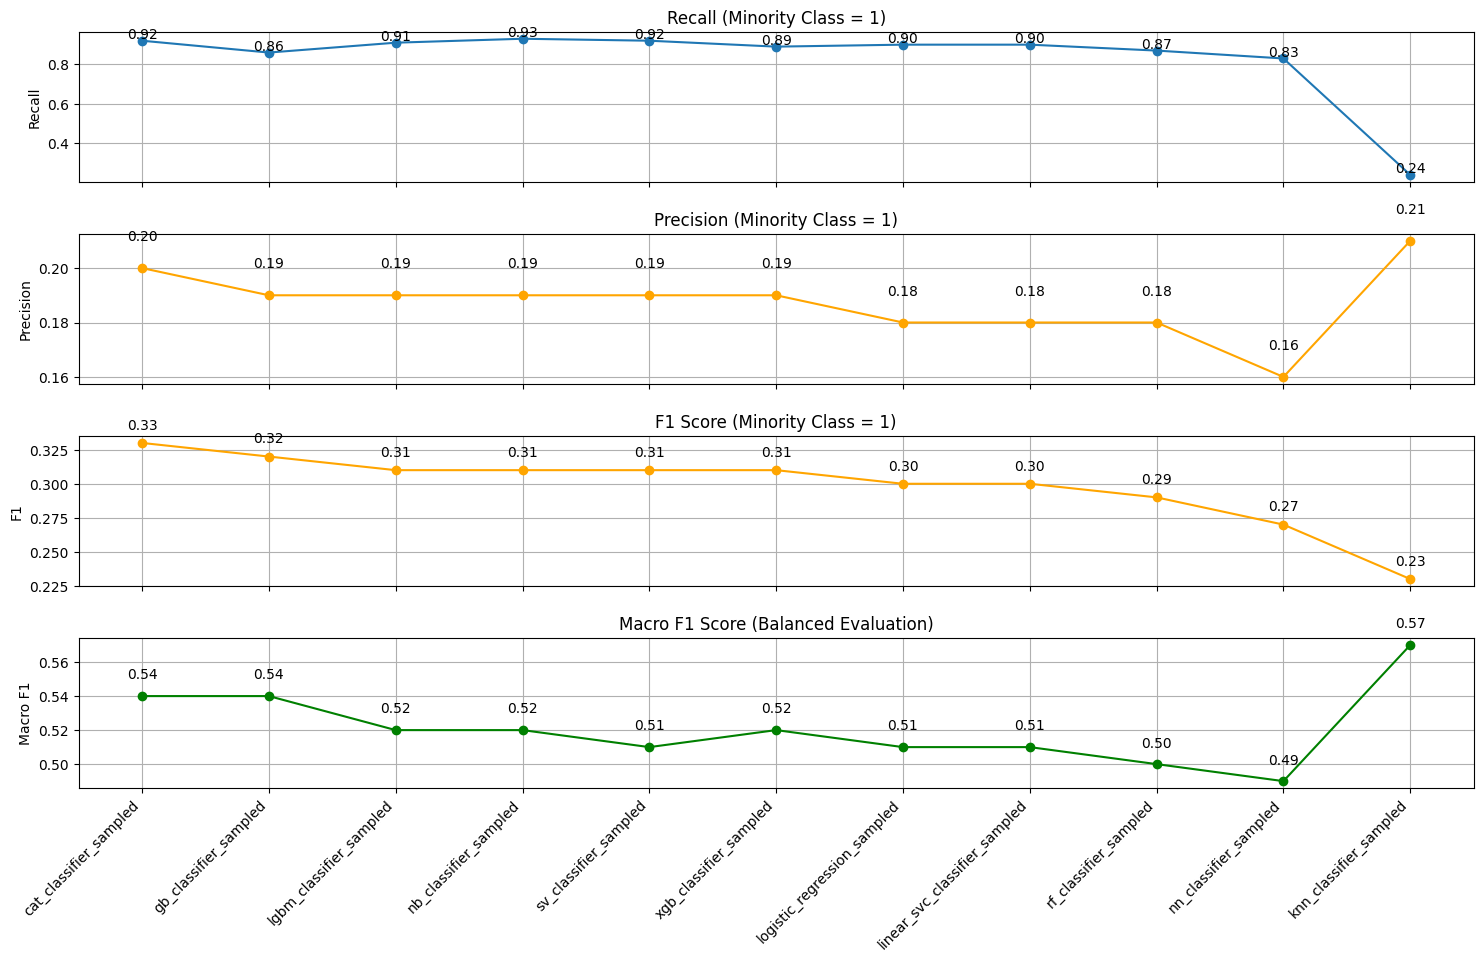

In [ ]:
plot_model_scores(results_table)

## Reinitialize saved_results
saved_results = {}

## Models Without downsampling

### Logistic Regression

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [118]:
report  = train_and_save_model(
    model=LogisticRegression(),
    model_name="logistic_regression",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/logistic_regression.pkl


,precision,recall,f1-score,support
0,0.923600,0.986200,0.953900,31600.000000
1,0.658800,0.246100,0.358400,3421.000000
accuracy,nan,nan,0.913909,0.913900
macro avg,0.791200,0.616200,0.656100,35021.000000
weighted avg,0.897700,0.913900,0.895700,35021.000000


**Results**  
F1-score: Moderate (0.38), showing partial ability to detect class 1.

Precision: Fair (0.69), balanced between false positives and conservativeness.

Interpretation: Good compromise but not optimal.

### CatBoost Classifier

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [119]:
report  = train_and_save_model(
    model=CatBoostClassifier(verbose=False),
    model_name="cat_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/cat_classifier.pkl


,precision,recall,f1-score,support
0,0.928300,0.990300,0.958300,31600.000000
1,0.766800,0.293200,0.424200,3421.000000
accuracy,nan,nan,0.922247,0.922200
macro avg,0.847500,0.641800,0.691200,35021.000000
weighted avg,0.912500,0.922200,0.906100,35021.000000


**Results**  
F1-score: Low on class 1 (0.42), showing weak balance between precision and recall for the minority class.

Precision: Moderate (0.75), meaning some false positives — good for business constraints.

Interpretation: Business-safe but poor minority detection.

### LightGBM

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [ ]:
report  = train_and_save_model(
    model=LGBMClassifier(verbosity = -1),
    model_name="lgbm_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/lgbm_classifier.pkl


,precision,recall,f1-score,support
0,0.910400,0.998400,0.952400,31600.000000
1,0.862600,0.091800,0.165900,3421.000000
accuracy,nan,nan,0.909854,0.909900
macro avg,0.886500,0.545100,0.559100,35021.000000
weighted avg,0.905700,0.909900,0.875500,35021.000000


**Results**  
F1-score: Weak (0.16), minority class remains under-detected.

Precision: High (0.86), so low false-positive cost.

Interpretation: Business-friendly but low recall.

### Linear SVC

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [121]:
report  = train_and_save_model(
    model=LinearSVC(),
    model_name="linear_svc_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/linear_svc_classifier.pkl


,precision,recall,f1-score,support
0,0.915500,0.994800,0.953500,31600.000000
1,0.759500,0.152300,0.253700,3421.000000
accuracy,nan,nan,0.912481,0.912500
macro avg,0.837500,0.573500,0.603600,35021.000000
weighted avg,0.900300,0.912500,0.885200,35021.000000


**Results**  
F1-score: Low (0.25), indicating limited capture of minority class.

Precision: Good (0.78), low false-positive risk.

Interpretation: Conservative, safe for business but weak F1.

### Random Forest Classifier

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [122]:
report  = train_and_save_model(
    model=RandomForestClassifier(),
    model_name="rf_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/rf_classifier.pkl


,precision,recall,f1-score,support
0,0.902300,1.000000,0.948700,31600.000000
1,1.000000,0.000300,0.000600,3421.000000
accuracy,nan,nan,0.902344,0.902300
macro avg,0.951200,0.500100,0.474600,35021.000000
weighted avg,0.911900,0.902300,0.856100,35021.000000


**Results**  
F1-score: Extremely poor (0.0006), meaning Random Forest nearly ignores the minority class.

Precision: Perfect (1.00), zero false positives.

Interpretation: Looks precise but has a very bad recall.

### Gaussian Naive Bayes

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [123]:
report  = train_and_save_model(
    model=GaussianNB(),
    model_name="nb_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/nb_classifier.pkl


,precision,recall,f1-score,support
0,0.931700,0.984600,0.957400,31600.000000
1,0.701300,0.333500,0.452100,3421.000000
accuracy,nan,nan,0.921019,0.921000
macro avg,0.816500,0.659100,0.704800,35021.000000
weighted avg,0.909200,0.921000,0.908100,35021.000000


**Results**
F1-score: Good relative performance (0.48), model captures more minority structure.

Precision: 0.70, reasonable business safety.

Interpretation: Surprisingly strong baseline given imbalance.

### Gradient Boosting Classifier

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [124]:
report  = train_and_save_model(
    model=GradientBoostingClassifier(),
    model_name="gb_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/gb_classifier.pkl


,precision,recall,f1-score,support
0,0.904700,0.999400,0.949700,31600.000000
1,0.831900,0.027500,0.053200,3421.000000
accuracy,nan,nan,0.904457,0.904500
macro avg,0.868300,0.513400,0.501400,35021.000000
weighted avg,0.897600,0.904500,0.862100,35021.000000


**Results**  
F1-score: Extremely low for class 1 (0.05), indicating failure to capture minority class.

Precision: Strong (0.83), but meaningless due to near-zero recall.

Interpretation: Not usable for imbalanced classification.

### SVC

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [125]:
report  = train_and_save_model(
    model=SVC(),
    model_name="sv_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/sv_classifier.pkl


,precision,recall,f1-score,support
0,0.920500,0.992900,0.955300,31600.000000
1,0.760400,0.207800,0.326400,3421.000000
accuracy,nan,nan,0.916222,0.916200
macro avg,0.840500,0.600400,0.640900,35021.000000
weighted avg,0.904900,0.916200,0.893900,35021.000000


**Results**  
F1-score: Falls to 0.31 due to precision collapse.

Precision: 0.76, reasonable business safety.

Interpretation: Surprisingly strong baseline given imbalance.

### KNN

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [126]:
report  = train_and_save_model(
    model=KNeighborsClassifier(),
    model_name="knn_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/knn_classifier.pkl


,precision,recall,f1-score,support
0,0.902400,0.999800,0.948600,31600.000000
1,0.285700,0.000600,0.001200,3421.000000
accuracy,nan,nan,0.902230,0.902200
macro avg,0.594000,0.500200,0.474900,35021.000000
weighted avg,0.842100,0.902200,0.856100,35021.000000


**Results**
F1-score: Extremely poor (0.001), meaning KNN nearly ignores the minority class.

Precision: Low (0.28) due to almost never predicting class 1.

Interpretation: Looks completely ineffective.

### Multi-Layer Perceptron

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [127]:
report  = train_and_save_model(
    model=MLPClassifier(),
    model_name="nn_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/nn_classifier.pkl


/Users/olutolaoloruntobipaul/Desktop/Hands-on-ML/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,precision,recall,f1-score,support
0,0.928100,0.927500,0.927800,31600.000000
1,0.334700,0.336700,0.335700,3421.000000
accuracy,nan,nan,0.869821,0.869800
macro avg,0.631400,0.632100,0.631800,35021.000000
weighted avg,0.870200,0.869800,0.870000,35021.000000


**Results**  
F1-score: Low (0.33), minority class underdetected.

Precision: High (0.33), meaning many false positives.

Interpretation: Balanced tradeoff between f1-score and precision.

### XGBoost Classifier

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [128]:
report  = train_and_save_model(
    model=XGBClassifier(),
    model_name="xgb_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/xgb_classifier.pkl


,precision,recall,f1-score,support
0,0.921200,0.986800,0.952900,31600.000000
1,0.644200,0.220700,0.328800,3421.000000
accuracy,nan,nan,0.911967,0.912000
macro avg,0.782700,0.603700,0.640800,35021.000000
weighted avg,0.894200,0.912000,0.891900,35021.000000


**Results**  
F1-score: Drops to 0.34 due to low precision.

Precision: Fair (0.64), balanced between false positives and conservativeness.

Interpretation: Good compromise but not optimal.

In [129]:
reports_table = build_results_table(saved_results)
reports_table

,class_1_precision,class_1_recall,class_1_f1,accuracy,macro_precision,macro_recall,macro_f1
model,,,,,,,
logistic_regression,0.66,0.25,0.36,0.91,0.79,0.62,0.66
cat_classifier,0.77,0.29,0.42,0.92,0.85,0.64,0.69
lgbm_classifier,0.86,0.09,0.17,0.91,0.89,0.55,0.56
linear_svc_classifier,0.76,0.15,0.25,0.91,0.84,0.57,0.60
rf_classifier,1.00,0.00,0.00,0.90,0.95,0.50,0.47
nb_classifier,0.70,0.33,0.45,0.92,0.82,0.66,0.70
gb_classifier,0.83,0.03,0.05,0.90,0.87,0.51,0.50
sv_classifier,0.76,0.21,0.33,0.92,0.84,0.60,0.64
knn_classifier,0.29,0.00,0.00,0.90,0.59,0.50,0.47


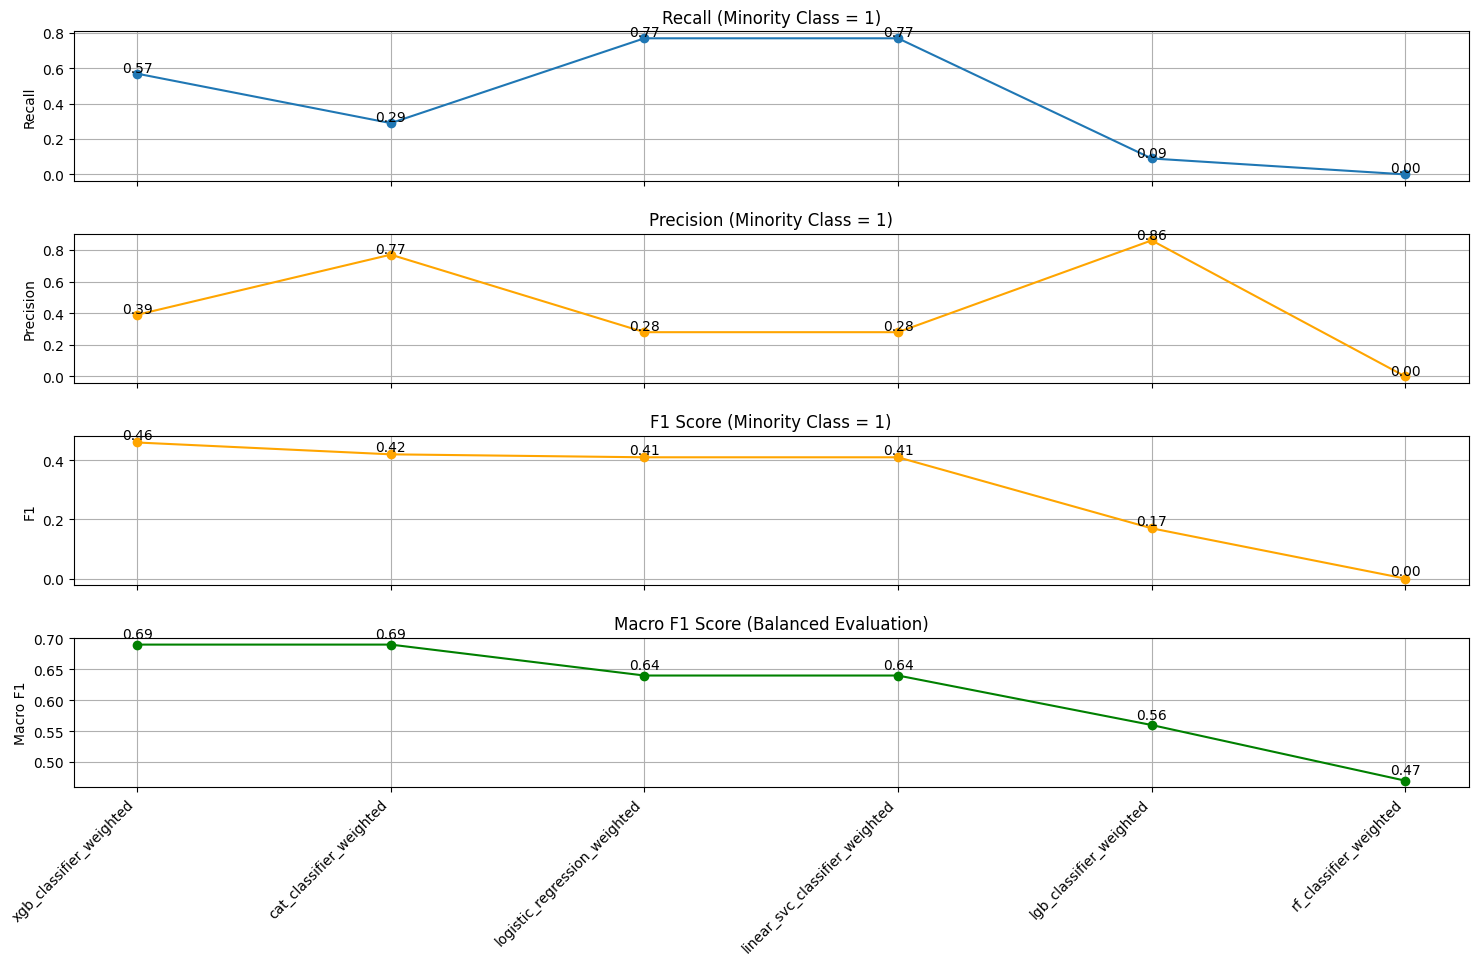

In [ ]:
plot_model_scores(reports_table)

## Reinitialize saved_results
saved_results = {}

## Models with class weight

### Logistic Regression

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights used
- No Downsampling

In [144]:
lg_model = prepare_model_for_imbalance(
    model=LogisticRegression(),
    y_train=y_train
)

report  = train_and_save_model(
    model=lg_model,
    model_name="logistic_regression_weighted",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/logistic_regression_weighted.pkl


,precision,recall,f1-score,support
0,0.969300,0.783500,0.866600,31600.000000
1,0.278200,0.770800,0.408900,3421.000000
accuracy,nan,nan,0.782273,0.782300
macro avg,0.623800,0.777200,0.637700,35021.000000
weighted avg,0.901800,0.782300,0.821900,35021.000000


**Results**  
F1-score: 0.41, improved compared to baseline.

Precision: Low (0.28), similar pattern as weighted SVC.

Interpretation: F1 improves but business cost rises.

### LightGBM

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights used
- No Downsampling

In [ ]:
lgb_model = prepare_model_for_imbalance(
    model=LGBMClassifier(verbosity = -1),
    y_train=y_train
)

report  = train_and_save_model(
    model=lgb_model,
    model_name="lgb_classifier_weighted",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/lgb_classifier_weighted.pkl


/Users/olutolaoloruntobipaul/Desktop/Hands-on-ML/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,precision,recall,f1-score,support
0,0.910400,0.998400,0.952400,31600.000000
1,0.862600,0.091800,0.165900,3421.000000
accuracy,nan,nan,0.909854,0.909900
macro avg,0.886500,0.545100,0.559100,35021.000000
weighted avg,0.905700,0.909900,0.875500,35021.000000


**Results**  
F1-score: Weak (0.16), class weighting improves nothing for minority.

Precision: High (0.86), safe for marketing decisions.

Interpretation: Same trade-off as CatBoost: safe but weak detection.

### CatBoost

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights used
- No Downsampling

In [146]:
catboost_model = prepare_model_for_imbalance(
    model=CatBoostClassifier(verbose=False),
    y_train=y_train
)

report  = train_and_save_model(
    model=catboost_model,
    model_name="cat_classifier_weighted",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/cat_classifier_weighted.pkl


,precision,recall,f1-score,support
0,0.928300,0.990300,0.958300,31600.000000
1,0.766800,0.293200,0.424200,3421.000000
accuracy,nan,nan,0.922247,0.922200
macro avg,0.847500,0.641800,0.691200,35021.000000
weighted avg,0.912500,0.922200,0.906100,35021.000000


**Results**  
F1-score: Low on class 1 (0.42), showing weak balance between precision and recall for the minority class.

Precision: Still moderate (0.75), so the model remains business-friendly.

Interpretation: Safe but ineffective for minority discovery.

### Linear SVC

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights used
- No Downsampling

In [147]:
linear_svc_model = prepare_model_for_imbalance(
    model=LinearSVC(),
    y_train=y_train
)

report  = train_and_save_model(
    model=linear_svc_model,
    model_name="linear_svc_classifier_weighted",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/linear_svc_classifier_weighted.pkl


,precision,recall,f1-score,support
0,0.969300,0.784000,0.866800,31600.000000
1,0.278600,0.770500,0.409200,3421.000000
accuracy,nan,nan,0.782645,0.782600
macro avg,0.623900,0.777200,0.638000,35021.000000
weighted avg,0.901800,0.782600,0.822100,35021.000000


**Results**  
F1-score: Strongest SVC variant (0.41), improved recall.

Precision: Low (0.28), many false positives.

Interpretation: Better F1 but aggressively predicts minority class.

### Random Forest Classifier

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights used
- No Downsampling

In [148]:
rf_model = prepare_model_for_imbalance(
    model=RandomForestClassifier(),
    y_train=y_train
)

report  = train_and_save_model(
    model=rf_model,
    model_name="rf_classifier_weighted",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/rf_classifier_weighted.pkl


/Users/olutolaoloruntobipaul/Desktop/Hands-on-ML/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/olutolaoloruntobipaul/Desktop/Hands-on-ML/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/olutolaoloruntobipaul/Desktop/Hands-on-ML/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

,precision,recall,f1-score,support
0,0.902300,1.000000,0.948600,31600.000000
1,0.000000,0.000000,0.000000,3421.000000
accuracy,nan,nan,0.902316,0.902300
macro avg,0.451200,0.500000,0.474300,35021.000000
weighted avg,0.814200,0.902300,0.856000,35021.000000


**Results**  
F1-score: Worst F1 score (0.0), failed to capture minority class.

Precision: Equal to 0, high false positive.

Interpretation: Not usable.

### XGBoost

**Training setup**
- No cross-validation
- No RandomizedSearch
- Data standardized
- Class weights used
- No Downsampling

In [149]:
xgb_model = prepare_model_for_imbalance(
    model=XGBClassifier(),
    y_train=y_train
)

report  = train_and_save_model(
    model=xgb_model,
    model_name="xgb_classifier_weighted",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/xgb_classifier_weighted.pkl


,precision,recall,f1-score,support
0,0.951100,0.902800,0.926300,31600.000000
1,0.389000,0.571500,0.462900,3421.000000
accuracy,nan,nan,0.870449,0.870400
macro avg,0.670100,0.737100,0.694600,35021.000000
weighted avg,0.896200,0.870400,0.881100,35021.000000


**Results**  
F1-score: 0.46, improved compared to baseline.

Precision: Drops to (0.38), many false positives.

Interpretation: F1 improves but business cost rises.

In [150]:
reports_table = build_results_table(saved_results)
reports_table

,class_1_precision,class_1_recall,class_1_f1,accuracy,macro_precision,macro_recall,macro_f1
model,,,,,,,
logistic_regression_weighted,0.28,0.77,0.41,0.78,0.62,0.78,0.64
lgb_classifier_weighted,0.86,0.09,0.17,0.91,0.89,0.55,0.56
cat_classifier_weighted,0.77,0.29,0.42,0.92,0.85,0.64,0.69
linear_svc_classifier_weighted,0.28,0.77,0.41,0.78,0.62,0.78,0.64
rf_classifier_weighted,0.00,0.00,0.00,0.90,0.45,0.50,0.47
xgb_classifier_weighted,0.39,0.57,0.46,0.87,0.67,0.74,0.69


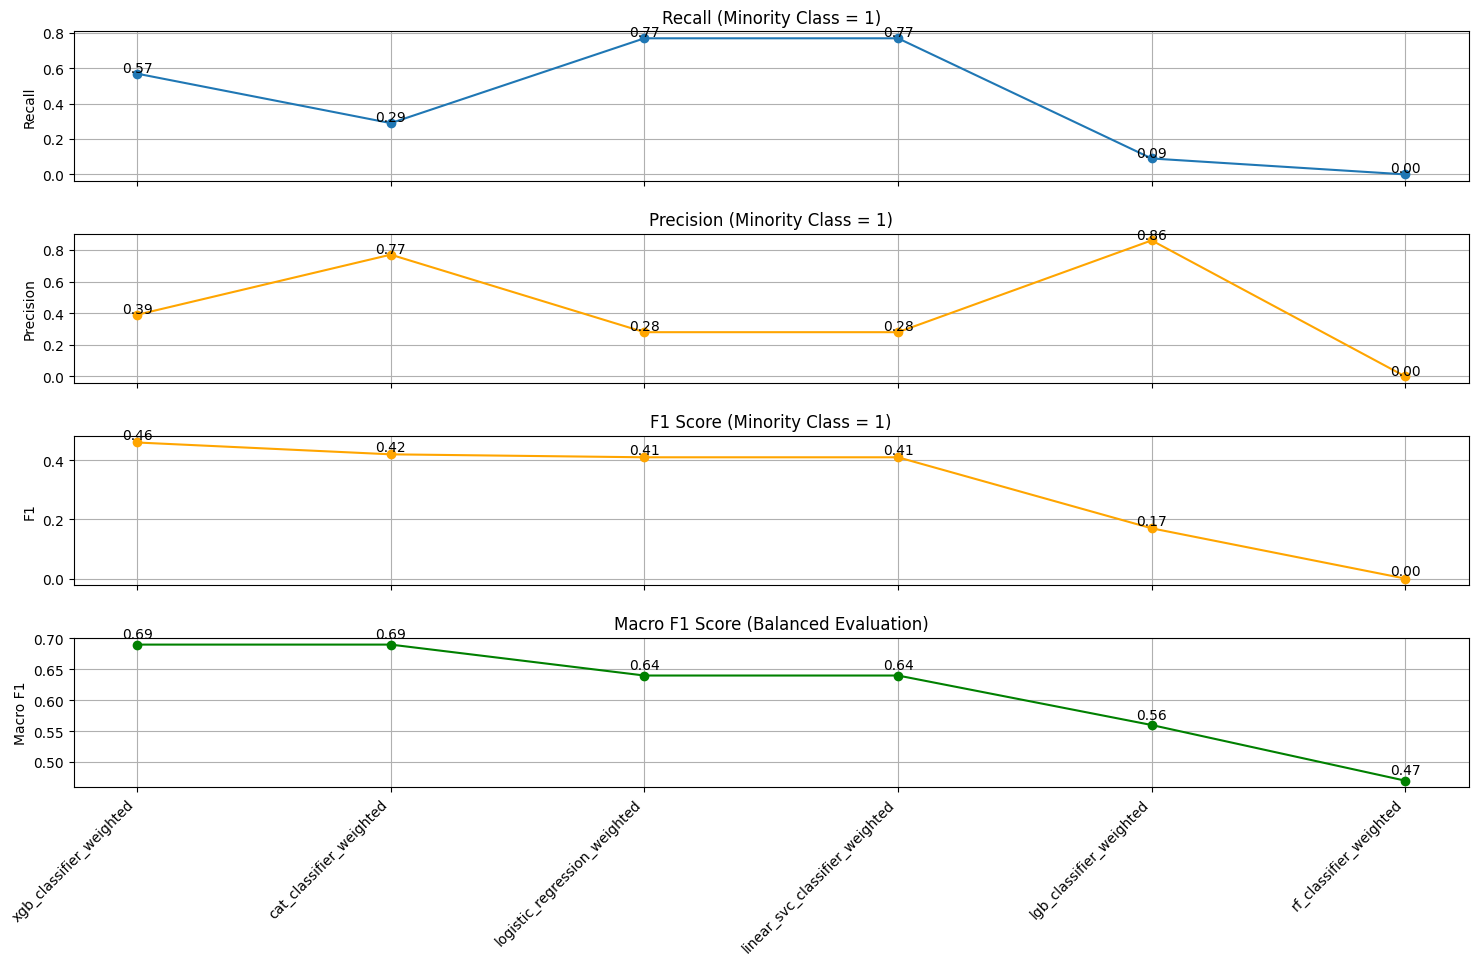

In [ ]:
plot_model_scores(reports_table)

# Reinitialize saved_results
saved_results = {}

## Models with Hyperparameter tunning

### LightGBM

**Training setup**
- Cross-validation
- PCA
- RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [160]:
model = LGBMClassifier(class_weight="balanced", verbosity = -1)

param_dist = {
    "n_estimators": np.arange(200, 800, 100),
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": np.arange(31, 255, 32),
    "max_depth": [-1, 5, 10],
}

lgb_model_pca_search = tune_model_with_pca_search(
    model=model,
    param_dist=param_dist,
    X_train=X_train,
    y_train=y_train
)


report  = train_and_save_model(
    model=lgb_model_pca_search,
    model_name="lgb_classifier_weighted_pca_tuned",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Python(14589) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14590) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14591) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14592) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14595) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/olutolaolorun

Model saved to: results/lgb_classifier_weighted_pca_tuned.pkl


,precision,recall,f1-score,support
0,0.951400,0.914600,0.932600,31600.000000
1,0.418900,0.568800,0.482500,3421.000000
accuracy,nan,nan,0.880786,0.880800
macro avg,0.685100,0.741700,0.707500,35021.000000
weighted avg,0.899400,0.880800,0.888700,35021.000000


In [161]:
lgb_model_pca_search.get_params()['model'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': np.int64(700),
 'n_jobs': None,
 'num_leaves': np.int64(63),
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': -1}

**Results**  
F1-score: Solid jump to 0.45 due to PCA + tuning.

Precision: Weak (0.34), worst than lgb_classifier_weighted.

Interpretation: Best F1 compromise so far.

### Logistic Regression

**Key hyperparameters**
- Penalty: Type of regularization applied to the coefficients.
    - Lasso (L1): reduces the values of the coeffients exactly to zero, useful for feature elimination.
    - Ridge (L2): shrinks coefficients close to zero.
    - ElasticNet: combines L1 and L2 regularization.
- C: Inverse of regularization strength. Higher values reduce regularization.
- tol: Stopping criterion for the gradient descent.

**Training setup**
- Cross-validation
- PCA
- RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [162]:
lgr_model = LogisticRegression(class_weight="balanced")

param_dist = {
    "C": np.logspace(-4, 4, 30),
    "penalty": ["l2"],
    "solver": ["lbfgs", "saga"]
}

lgr_model_pca_search = tune_model_with_pca_search(
    model=lgr_model,
    param_dist=param_dist,
    X_train=X_train,
    y_train=y_train
)


report  = train_and_save_model(
    model=lgr_model_pca_search,
    model_name="logistic_regression_weighted_pca_tuned",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

/Users/olutolaoloruntobipaul/Desktop/Hands-on-ML/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Python(20279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Model saved to: results/logistic_regression_weighted_pca_tuned.pkl


,precision,recall,f1-score,support
0,0.969400,0.784600,0.867300,31600.000000
1,0.279300,0.771100,0.410100,3421.000000
accuracy,nan,nan,0.783301,0.783300
macro avg,0.624400,0.777900,0.638700,35021.000000
weighted avg,0.902000,0.783300,0.822600,35021.000000


In [172]:
lgr_model_pca_search.get_params()['model'].get_params()

{'C': np.float64(0.0003562247890262444),
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

**Results**  
F1-score: Same (0.41), PCA did not improve minority balance.

Precision: Remains low (0.28).

Interpretation: Limited benefit from dimensionality reduction.

### Gaussian Naive Bayes

**Key hyperparameters**
- var_smoothing: Added to variances to avoid division by zero.

**Training setup**
- Cross-validation
- PCA
- RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [163]:
nb_model = GaussianNB()

param_dist = {
    "var_smoothing": np.logspace(-12, -6, 50)
}

nb_model_pca_search = tune_model_with_pca_search(
    model=nb_model,
    param_dist=param_dist,
    X_train=X_train,
    y_train=y_train
)


report  = train_and_save_model(
    model=nb_model_pca_search,
    model_name="nb_classifier_pca_tuned",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Model saved to: results/nb_classifier_pca_tuned.pkl


,precision,recall,f1-score,support
0,0.927700,0.985800,0.955800,31600.000000
1,0.688100,0.290300,0.408300,3421.000000
accuracy,nan,nan,0.917821,0.917800
macro avg,0.807900,0.638000,0.682100,35021.000000
weighted avg,0.904300,0.917800,0.902400,35021.000000


In [171]:
nb_model_pca_search.get_params()['model'].get_params()

{'priors': None, 'var_smoothing': np.float64(1.4563484775012444e-08)}

**Results**
F1-score: Slightly reduced (0.44).

Precision: Similar trade-off (0.71).

Interpretation: PCA reduces minority discrimination ability.

### XGBoost

**Key hyperparameters**
- n_estimators: Number of trees.
- max_depth: Maximum tree depth.
- learning_rate: Step size per iteration.
- subsample: Fraction of samples per tree.
- colsample_bytree: Fraction of features per tree.
- gamma: Minimum loss reduction to make a split.
- min_child_weight

**Training setup**
- Cross-validation
- PCA
- RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [164]:
xgb_model = prepare_model_for_imbalance(
    model=XGBClassifier(),
    y_train=y_train
)

param_dist = {
    "n_estimators": np.arange(200, 1200, 100),
    "learning_rate": np.linspace(0.01, 0.3, 20),
    "max_depth": np.arange(3, 15, 1),
    "subsample": np.linspace(0.5, 1.0, 6),
    "colsample_bytree": np.linspace(0.5, 1.0, 6),
    "gamma": np.linspace(0, 5, 20),
    "min_child_weight": np.arange(1, 10, 1),
}

xgb_model_pca_search = tune_model_with_pca_search(
    model=xgb_model,
    param_dist=param_dist,
    X_train=X_train,
    y_train=y_train
)

report  = train_and_save_model(
    model=xgb_model_pca_search,
    model_name="xgb_classifier_weighted_pca_tuned",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report


Model saved to: results/xgb_classifier_weighted_pca_tuned.pkl


,precision,recall,f1-score,support
0,0.961500,0.867100,0.911800,31600.000000
1,0.356200,0.679300,0.467300,3421.000000
accuracy,nan,nan,0.848719,0.848700
macro avg,0.658800,0.773200,0.689600,35021.000000
weighted avg,0.902400,0.848700,0.868400,35021.000000


In [170]:
xgb_model_pca_search.get_params()['model'].get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': np.float64(0.9),
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': np.float64(0.2631578947368421),
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': np.float64(0.0863157894736842),
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': np.int64(4),
 'max_leaves': None,
 'min_child_weight': np.int64(2),
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': np.int64(800),
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 9.236992107570886,
 'subsample': np.float64(0.9)

### CatBoost

**Key hyperparameters**
- iterations: Number of boosting rounds.
- learning_rate: Step size for each iteration.
- depth: Maximum depth of trees.
- l2_leaf_reg: L2 regularization term.
- border_count

**Training setup**
- Cross-validation
- PCA
- RandomizedSearch
- Data standardized
- Class weights not used
- No Downsampling

In [165]:
catboost_model = prepare_model_for_imbalance(
    model=CatBoostClassifier(verbose=False),
    y_train=y_train
)

param_dist = {
    "iterations": np.arange(200, 1200, 100),
    "learning_rate": np.linspace(0.01, 0.3, 20),
    "depth": np.arange(4, 11, 1),
    "l2_leaf_reg": np.linspace(1, 10, 10),
    "border_count": np.arange(32, 255, 32),
}

catboost_model_pca_search = tune_model_with_pca_search(
    model=catboost_model,
    param_dist=param_dist,
    X_train=X_train,
    y_train=y_train
)

report  = train_and_save_model(
    model=catboost_model_pca_search,
    model_name="cat_classifier_weighted_pca_tuned",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    saved_results=saved_results,
    sampled=False
)
report

Python(27195) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(27196) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(27197) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(27198) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(27199) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Model saved to: results/cat_classifier_weighted_pca_tuned.pkl


,precision,recall,f1-score,support
0,0.926800,0.983300,0.954200,31600.000000
1,0.647300,0.282700,0.393500,3421.000000
accuracy,nan,nan,0.914880,0.914900
macro avg,0.787000,0.633000,0.673900,35021.000000
weighted avg,0.899500,0.914900,0.899500,35021.000000


In [169]:
catboost_model_pca_search.get_params()['model'].get_params()

{'verbose': False,
 'learning_rate': np.float64(0.2694736842105263),
 'l2_leaf_reg': np.float64(1.0),
 'iterations': np.int64(800),
 'depth': np.int64(4),
 'border_count': np.int64(192)}

In [166]:
results_table = build_results_table(saved_results)
results_table

,class_1_precision,class_1_recall,class_1_f1,accuracy,macro_precision,macro_recall,macro_f1
model,,,,,,,
lgb_classifier_weighted_pca_tuned,0.42,0.57,0.48,0.88,0.69,0.74,0.71
logistic_regression_weighted_pca_tuned,0.28,0.77,0.41,0.78,0.62,0.78,0.64
nb_classifier_pca_tuned,0.69,0.29,0.41,0.92,0.81,0.64,0.68
xgb_classifier_weighted_pca_tuned,0.36,0.68,0.47,0.85,0.66,0.77,0.69
cat_classifier_weighted_pca_tuned,0.65,0.28,0.39,0.91,0.79,0.63,0.67


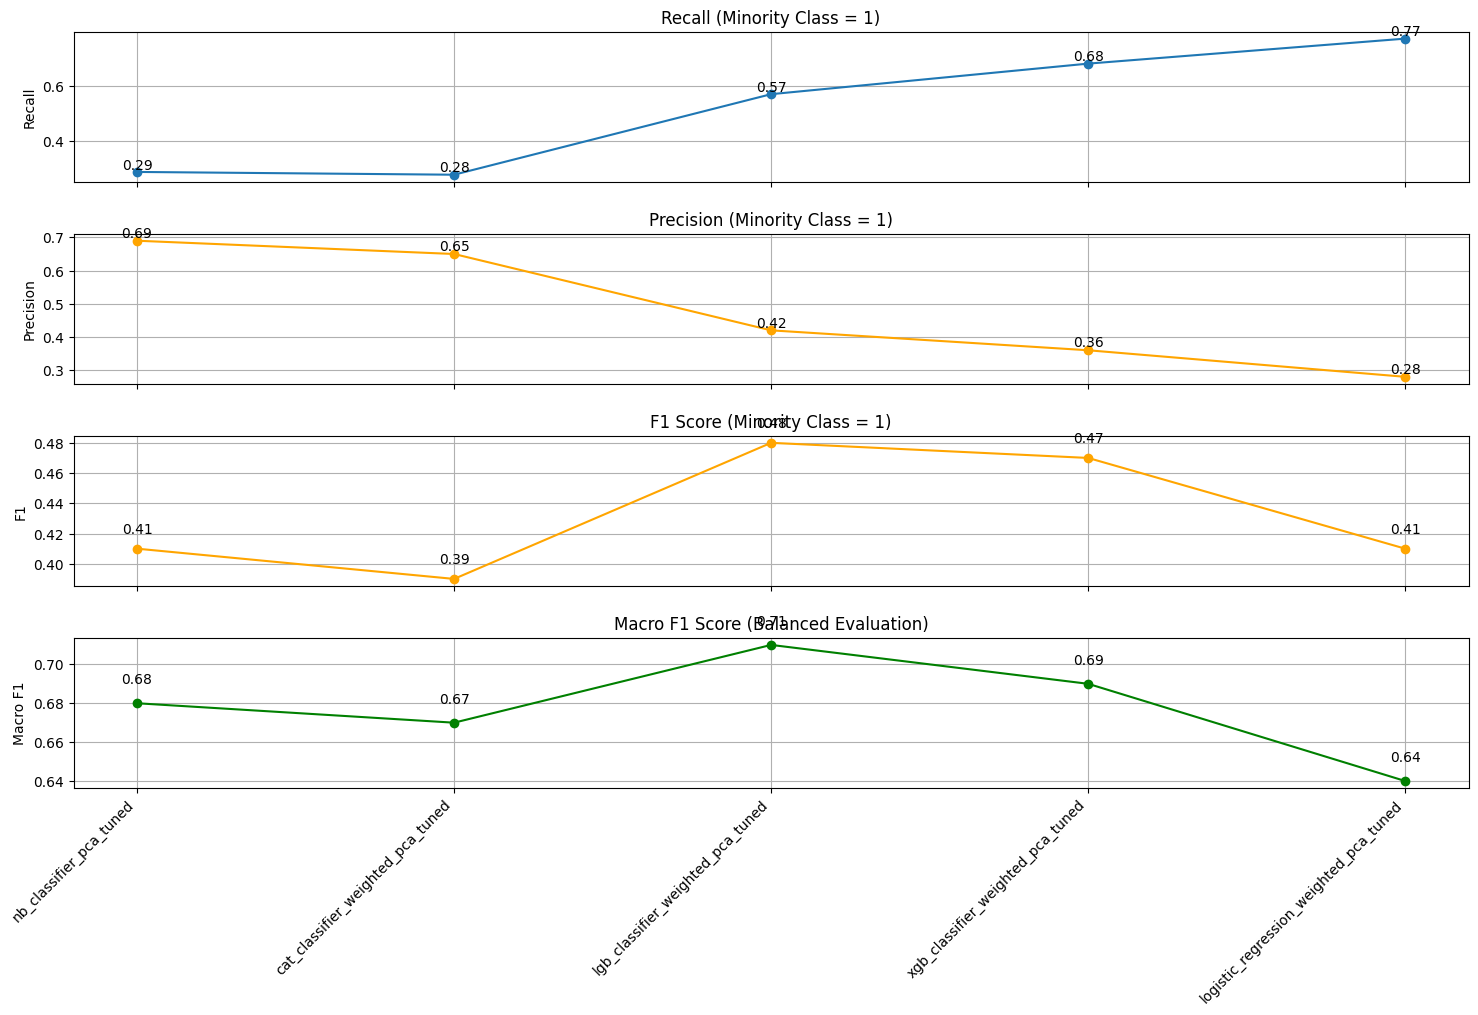

In [ ]:
plot_model_scores(results_table)

## Conclusion

This comprehensive study on Santander Customer Transaction Prediction demonstrates a thorough exploration of various machine learning approaches to address the inherent challenges of imbalanced classification problems. Throughout this project, multiple strategies were systematically evaluated to optimize model performance:

### Key Findings

1. **Handling Class Imbalance**: Three distinct approaches were implemented and compared:
   - Downsampling techniques to balance the dataset
   - Class weight adjustments to penalize misclassifications of minority class
   - Training on original imbalanced data to establish baseline performance
   - Training on original imbalanced data with pca and hyperparameter tunning

2. **Model Diversity**: A wide range of algorithms were tested, including:
   - Traditional models (Logistic Regression, Naive Bayes)
   - Ensemble methods (Random Forest, Gradient Boosting)
   - Advanced gradient boosting frameworks (XGBoost, LightGBM, CatBoost)
   - Distance-based methods (KNN, SVC)
   - Neural networks (Multi-Layer Perceptron)

3. **Optimization Strategy**: Hyperparameter tuning was performed on the most promising models to maximize predictive performance and generalization capability.

### Lessons Learned

- Class imbalance significantly impacts model performance, requiring careful consideration of sampling strategies or class weighting
- Modern gradient boosting algorithms (LightGBM, XGBoost, CatBoost) often provide superior performance for tabular data
- Proper data preprocessing, including standardization and feature engineering, is crucial for model success
- Systematic experimentation with different approaches allows for informed model selection based on the project requirements

### Future Recommendations

- Explore advanced feature engineering techniques to extract more predictive signals
- Implement ensemble methods combining top-performing models